# Datan esittäminen kartalla

Tässä harjoituksessa tarkoituksena on esittää maailman valtioiden vuotuiset hiilidioksidipäästöt henkilöä kohden kartan muodossa. Data voitaisiin esittää monin eri tavoin, kuten vaikkapa taulukossa, josta voisi suhteellisen helposti etsiä tietty valtion ja sen hiilidioksidipäästöt. Jos tavoitteenamme on kuitenkin saada kokonaiskuva kaikkien valtioiden päästöistä, on datan esittäminen kartalla oiva valinta. Piirrämme siis maailmankartan, ja väritämme valtiot sitä tummemmaksi, mitä suuremmat hiilidioksidipäästöt niillä on.

Tässä esimerkissä käytetty data on peräisin [Maailmanpankin sivustolla](https://databank.worldbank.org/home), josta on saatavilla paljon muutakin mielenkiintoista dataa.

Aloitetaan hankkimalla haluamamme data. Tätä esimerkkiä varten tiedostot ovat valmiiksi ladattuina ja löytyvät kansiosta 'data'.

Valtioiden geometriset muodot, joita piirtämiseen tarvitaan voidaan lukea .shp-päätteisestä tiedostosta.
GeoPandas-kirjastossa on valmiina käytettävissä valtioiden geometriset muodot, mutta halutessaan niistä voi ladata korkeampiresoluutioisen version esimerkiksi osoitteesta [https://www.naturalearthdata.com/downloads/](https://www.naturalearthdata.com/downloads/). Netistä löytyy myös muita .shp-tiedostoja, jotka voivat sisältää esimerkiksi Suomen kunnat.

Hiilidioksidipäästödata on peräisin osoitteesta [https://databank.worldbank.org/source/world-development-indicators#](https://databank.worldbank.org/source/world-development-indicators#).

Datatiedostojen lukemiseen käytetään yleensä 'Pandas'-kirjastoa. Geodatan (valtioiden muodot) lukemiseen käytetään kuitenkin 'GeoPandas'-nimistä kirjastoa. Aloitetaan datan tutkiminen tuomalla tarvittavat kirjastot.

In [1]:
import pandas as pd             # Pandas-kirjastolla luetaan ja käsitellään dataa
import geopandas as gpd         # GeoPandas on kuin Pandas, mutta sisältää myös geometristä dataa
import matplotlib.pyplot as plt # Matplotlib-kirjastolla visualisoidaan data

GeoPandas sisältää valmiiksi muutamia geometrisia tietoja, joista yksi on valtioiden muodot.
Luetaan kyseinen data ja katsotaan, mitä se sisältää.

In [2]:
# Luetaan geometrinen data valtioille ja tallennetaan tiedot muuttujaan 'world'
#world = gpd.read_file('data/countries/countries.shp')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Tulostetaan muutama ensimmäinen rivi datasta
print(world.head())

     pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  


Katsotaan datan sisältämät sarakkeet.

In [3]:
print(world.columns)

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


Voimme piirtää geopandasilla lukemamme datan suoraan käyttämällä 'plot'-käskyä

<AxesSubplot:>

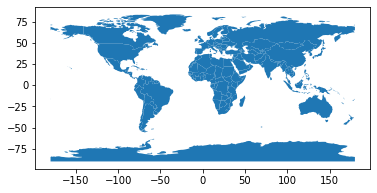

In [4]:
world.plot()

Luetaan seuraavaksi hiilidioksidipäästödata ja katsotaan, mitä se pitää sisällään.

In [5]:
# Luetaan CO2-päästöjen data ja tallennetaan se muuttujaan 'CO2_2014'.
# Huom. joidenkin maiden nimeä on muokattu vastaamaan nimiä aiemmin ladatussa tiedostossa.
CO2_2014 = pd.read_csv('../data/CO2-emissions-per-capita-2014.csv')

# Tulostetaan muutama ensimmäinen rivi datasta
print(CO2_2014.head())

     Country Name Country Code                             Series Name  \
0     Afghanistan          AFG  CO2 emissions (metric tons per capita)   
1         Albania          ALB  CO2 emissions (metric tons per capita)   
2         Algeria          DZA  CO2 emissions (metric tons per capita)   
3  American Samoa          ASM  CO2 emissions (metric tons per capita)   
4         Andorra          AND  CO2 emissions (metric tons per capita)   

      Series Code      2014 [YR2014]  
0  EN.ATM.CO2E.PC  0.253727945460333  
1  EN.ATM.CO2E.PC   1.90006971019389  
2  EN.ATM.CO2E.PC   3.73580277736793  
3  EN.ATM.CO2E.PC                 ..  
4  EN.ATM.CO2E.PC   5.83290621488897  


Huomataan, että hiilidioksidipäästöjen data on sarakkeessa "2014 [YR2014]" yksikössä tonnia per henkilö (vuodessa). Lisäksi valtioiden nimen tai koodin sisältävä sarake on nimetty eri tavalla kuin toisessa datatiedostossa. Tämä täytyy ottaa huomioon datatiedostoja yhdistettäessä. Kun haluamme piirtää valtiokohtaista dataa kartalle, meidän on yhdistettävä eri datasetit siten, että saman valtion geometriatiedot yhdistyvät sen hiilidioksiditietoihin. Tämä onnistuu 'merge'-funktiolla.

In [6]:
import numpy as np

# Varmistetaan, että päästöluvut on annettu numeroina eikä tekstinä
CO2_2014 = CO2_2014.replace('..',np.nan)
CO2_2014['2014 [YR2014]'] = CO2_2014['2014 [YR2014]'].astype('float64')

# Yhdistetään 'world'-data 'name' sarakkeen mukaan 'CO2_2014'-datan 'Country Name'-sarakkeeseen.
data = world.merge(CO2_2014, left_on='name', right_on='Country Name')

Nyt kun data on yhdistetty, voimme piirtää sen.

<AxesSubplot:>

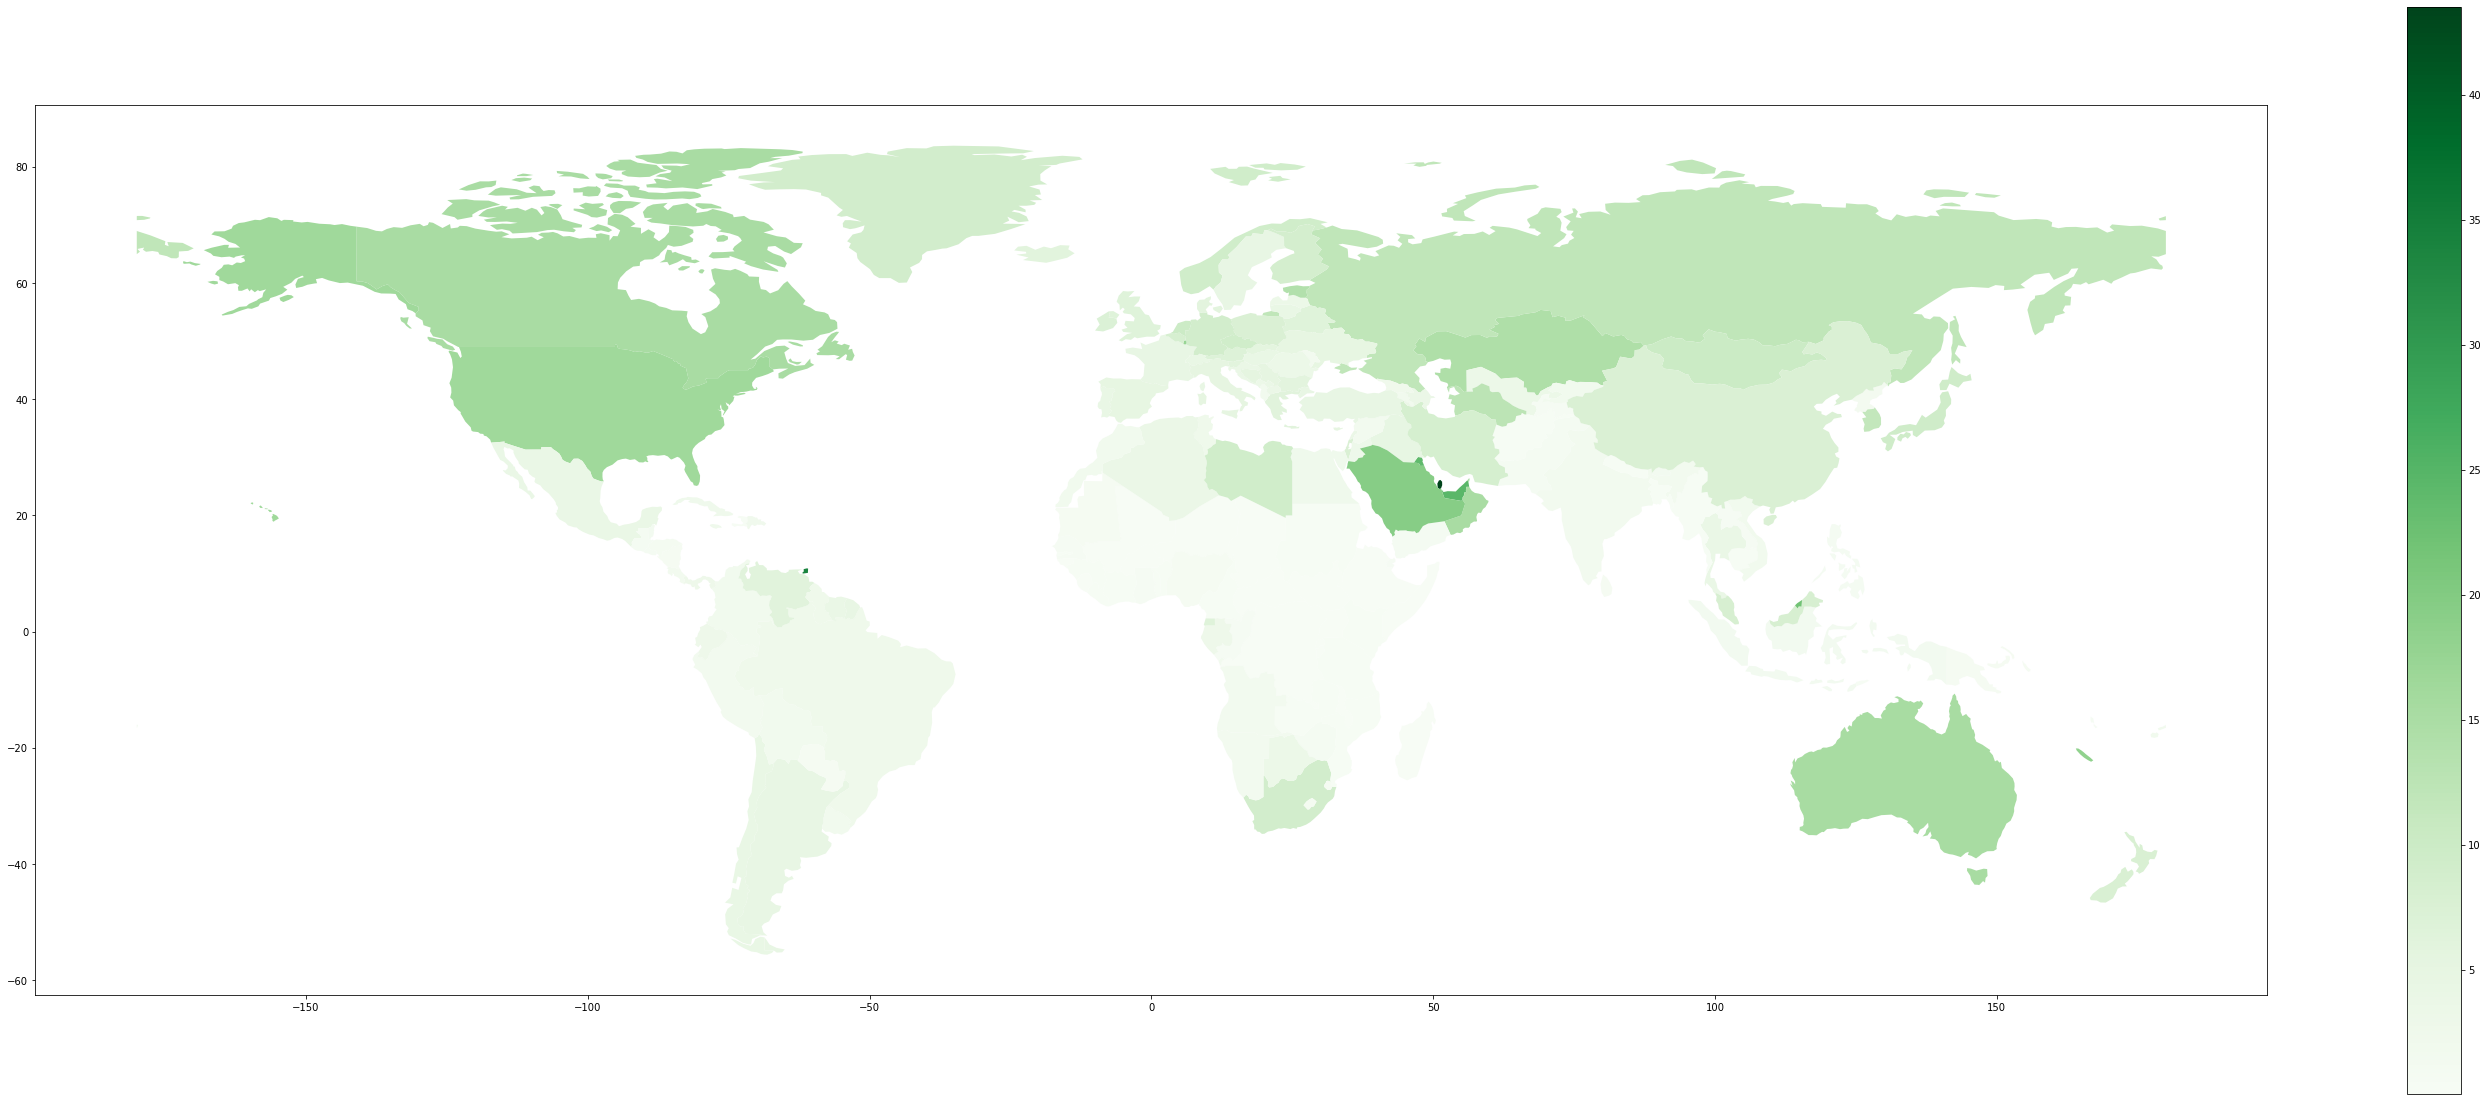

In [7]:
data.plot(column='2014 [YR2014]', figsize=(50,20), cmap='Greens', legend=True, k=6) # 6 eri väriä

Nyt näemme jo, että eri valtioiden päästöt ovat erilaiset. Kuvasta on kuitenkin vaikea hahmottaa, minkä valtioden päästöt ovat suurimpia.

Matplotlib jakaa värit automaattisesti siten, että kukin väri vastaa yhtä suurta osaa tarkasteluvälillä (0,04 - 43,52). Jakauma ei ole kuitenkaan tasainen, joten parempi tapa olisi jakaa värit siten, että kuhunkin väriin osuisi suunnilleen sama määrä valtioita. Tämä on tehty seuraavassa koodisolussa. Piirretään lisäksi taustalle kaikki valtiot harmaalla, jotta näemme, mistä valtioista ei ole dataa saatavilla.

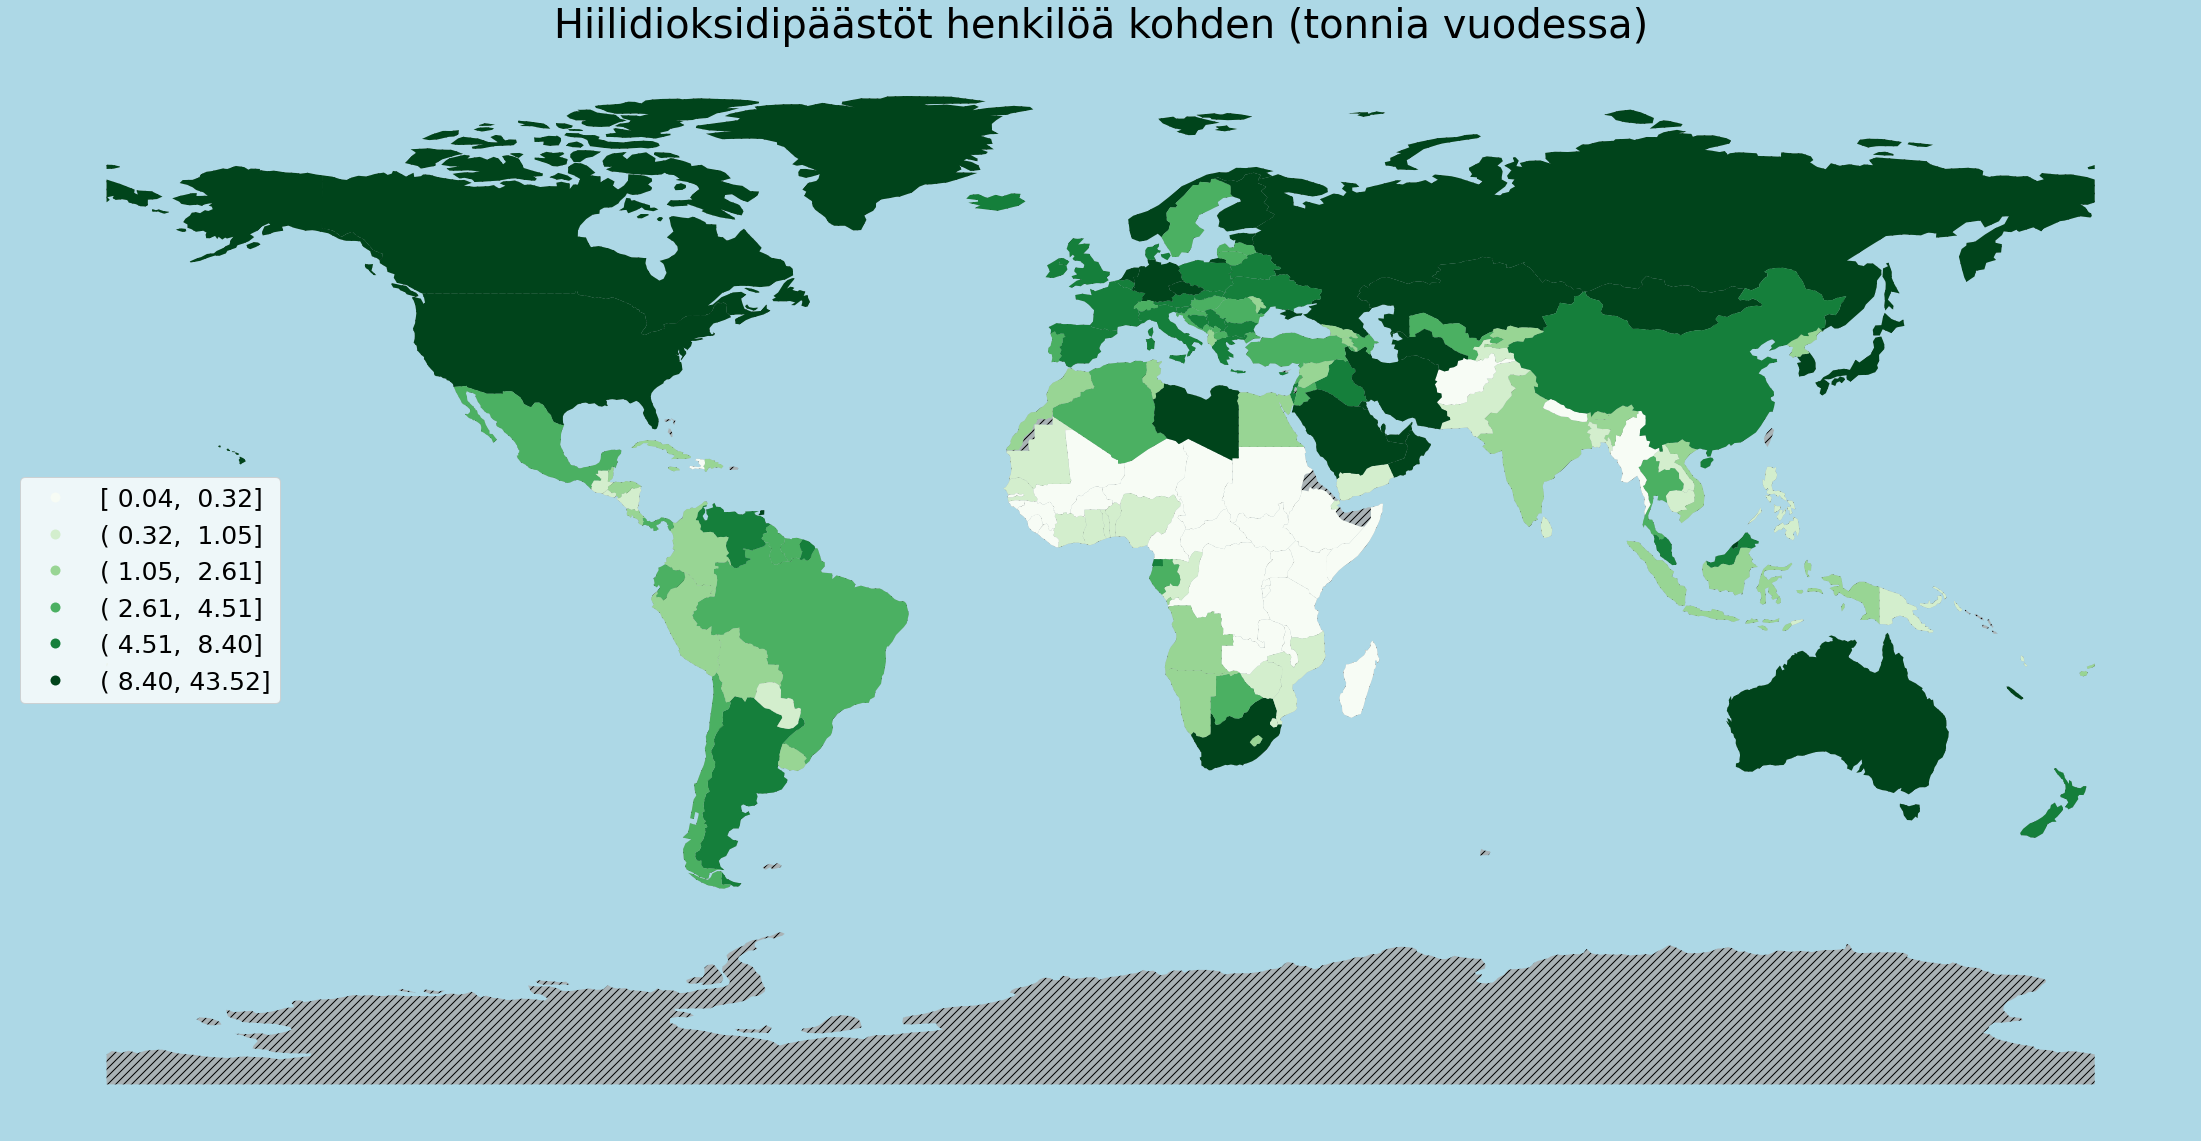

In [8]:
# Valmistellaan kuva, tehdään kuvasta suuri ja asetetaan taustaväriksi sininen
fig, ax = plt.subplots(1, figsize=(50,20), facecolor='lightblue')

# Piirretään taustaksi kaikki maat ja täytetään ne viivoilla.
# Tällöin ne maat, joista ei ole dataa, erottuvat helpommin.
world.plot(ax=ax, color='darkgrey', alpha=0.8, hatch= "///")

# Piirretään data taustan päälle
data.plot(
    column='2014 [YR2014]', # Määritetään piirrettävä sarake
    ax=ax,                  # Piirretään kuva samalle akselille kuin tausta
    cmap='Greens',          # Käytetään vihreää värikarttaa 
    legend=True,            # Lisätään selite
    legend_kwds={           #
        'fontsize': 25,     # Asetetaan selitteen fonttikoko
        'loc':'center left' # Asetetaan selitteen sijainti
    },                      #
    scheme='quantiles',     # Jaetaan datan värit samankokoisiin osiin
    k=6                     # Valitaan osien lukumääräksi 6
)

# Lisätään kuvalle otsikko
plt.title('Hiilidioksidipäästöt henkilöä kohden (tonnia vuodessa)',fontsize = 40)

# Poistetaan akselit kuvan reunoilta
ax.axis('off')

# näytetään kuva
plt.show()


Nyt kartasta erottaa jo huomattavasti paremmin eri alueet ja niitä vastaavat hiilidioksidipäästöt. Voit kokeilla piirtää datan myös jakamalla datan useampaan tai vähempään kuin kuuteen osaan. Miltä data tällöin näyttää? Muokkaa kuvaa haluamallasi tavalla.

Etsi itse jokin toinen valtiokohtainen data ja piirrä se samaan tapaan. Valtiokohtaista dataa löytää googlaamalla tai esimerkiksi osoitteesta [https://databank.worldbank.org/source/world-development-indicators#](https://databank.worldbank.org/source/world-development-indicators#). Maailmanpankin sivuilta pystyy myös tarkastelemaan dataa kartalla, mutta kokeile piirtää se itse!